In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn import decomposition
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dataframe import
with open('Data/part2.pkl', 'rb') as f:
    my_unpickler = pickle.Unpickler(f)
    main_df = my_unpickler.load()

main_df.head()

,Country,pop_evol (%),PIB 2013,kcal_total_capita_day,proteins_total_capita_day,proteins_animal_ratio,clusters,F1,F2,F3,cluster
0,Arménie,-1.943347,3838.180041,2924.0,90.06,0.480235,5,0.511589,-1.086613,-0.382163,Pauvres et mal nourris
1,Afghanistan,32.168195,608.058642,2087.0,58.26,0.209749,1,-2.648007,0.435521,0.378822,Très Pauvres et très mal nourris
2,Albanie,-2.037666,4399.863881,3188.0,111.37,0.533537,4,1.562424,-0.928378,-0.979067,Riches et bien nourris
3,Algérie,18.801321,5499.587619,3293.0,91.92,0.271867,5,0.111197,0.273961,-1.481151,Pauvres et mal nourris
4,Angola,39.238700,5254.883253,2474.0,57.27,0.321285,1,-1.883234,0.894616,0.308438,Très Pauvres et très mal nourris


Commençons par regarder la distribution de chacune de nos variables

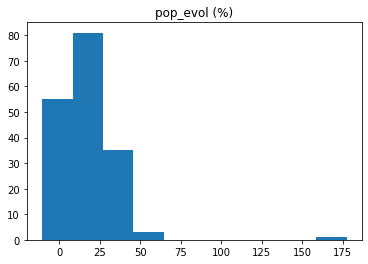

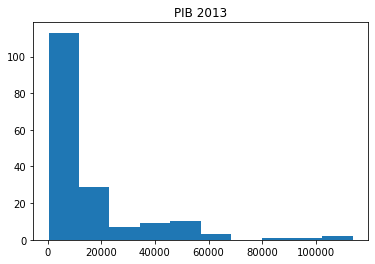

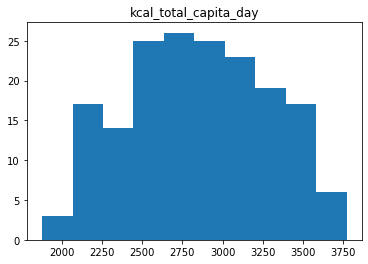

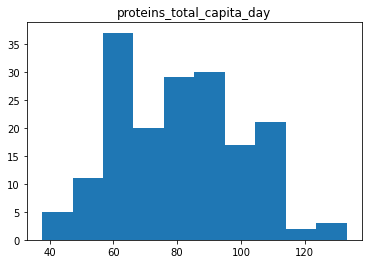

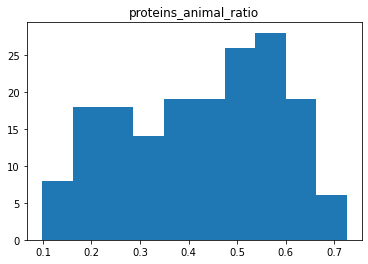

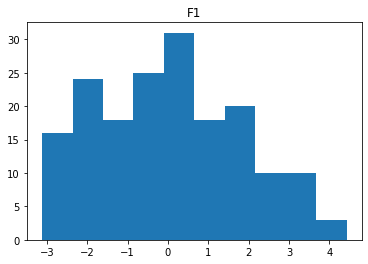

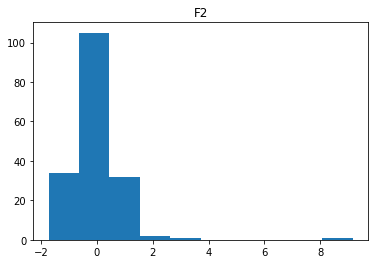

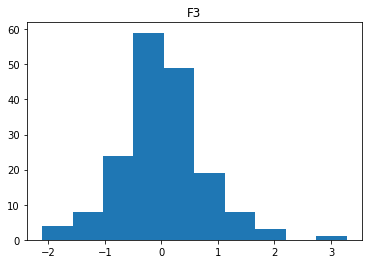

In [3]:
df_distrib = main_df.drop(['Country','clusters','cluster'],1,inplace=False)
for column in df_distrib.columns:
    plt.hist(df_distrib[column])
    plt.title(column)
    plt.show()

# Recherche d'une variable gaussienne avec le test de Shapiro-Wilk
Nous partons de l'hypothèse nulle H0 que nos variables sont gaussiennes. Notre hypothèse alternative étant que la variable n'est pas gaussienne.

Nous fixons notre seuil de risque à 1%, afin de ne pas rejeter trop facilement les variables candidates.

In [4]:
alpha = 0.01
for var in df_distrib.columns:
  stat, p = st.shapiro(df_distrib[var])
  print(var+': Stats = %.3f, p = %.3f' % (stat, p))

  if p > alpha:
    print(f"L'échantillon a été tiré d'une distribution gaussienne (fail to reject H0)")
    print(f" ")
  else:
    print(f"L'échantillon n'a pas été tiré d'une distribution gaussienne (reject H0)")
    print(f" ")

pop_evol (%): Stats = 0.709, p = 0.000
L'échantillon n'a pas été tiré d'une distribution gaussienne (reject H0)
 
PIB 2013: Stats = 0.685, p = 0.000
L'échantillon n'a pas été tiré d'une distribution gaussienne (reject H0)
 
kcal_total_capita_day: Stats = 0.984, p = 0.041
L'échantillon a été tiré d'une distribution gaussienne (fail to reject H0)
 
proteins_total_capita_day: Stats = 0.983, p = 0.028
L'échantillon a été tiré d'une distribution gaussienne (fail to reject H0)
 
proteins_animal_ratio: Stats = 0.960, p = 0.000
L'échantillon n'a pas été tiré d'une distribution gaussienne (reject H0)
 
F1: Stats = 0.975, p = 0.003
L'échantillon n'a pas été tiré d'une distribution gaussienne (reject H0)
 
F2: Stats = 0.678, p = 0.000
L'échantillon n'a pas été tiré d'une distribution gaussienne (reject H0)
 
F3: Stats = 0.971, p = 0.001
L'échantillon n'a pas été tiré d'une distribution gaussienne (reject H0)
 


Il existe deux variables pour lesquelles nous ne rejettons pas l'hypothèse nulle au seuil de 1% : 'kcal_total_capita_day" et "proteins_total_capita_day".

Pour la suite des tests nous ne considérons que la variable "proteins_total_capita_day".

# Observons la distribution des données

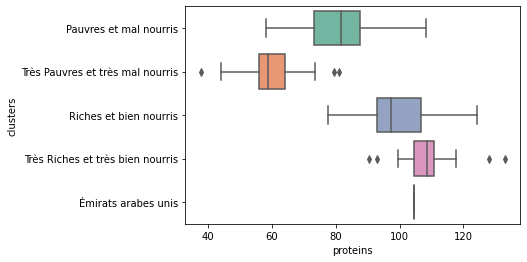

In [5]:
anova = pd.DataFrame({'clusters': main_df['cluster'] ,
                   'proteins': main_df['proteins_total_capita_day']})

ax = sns.boxplot(x='proteins', y='clusters', data=anova, palette="Set2")
plt.show()


Testons les 2 clusters qui semblent le plus proches graphiquement: "Riches et bien nourris" et "Pauvres et mal nourris"

In [6]:
proteins_cluster1 = main_df[main_df['cluster'] == "Riches et bien nourris"]['proteins_total_capita_day']
proteins_cluster2 = main_df[main_df['cluster'] == "Pauvres et mal nourris"]['proteins_total_capita_day']

# Test Bartlett - Test d'égalité des variances
Vérifions si les variances sont similaires.  
- Hypothèse nulle : Les variances sont similaires.  
- Hypothèse alternative : Les variances sont différentes.  

On rejettera H0 à un seuil de 5% (alpha = 0.05)

In [7]:
stat, p = st.bartlett(proteins_cluster1, proteins_cluster2)
print('stat = %.3f, p-value = %.3f' % (stat, p))
if p > 0.05:
	print('L\'hypothèse nulle n\'est pas rejetée - Les variances sont probablement similaires')
else:
	print('L\'hypothèse nulle est rejetée - Les variances sont probablement différentes')

stat = 0.034, p-value = 0.853
L'hypothèse nulle n'est pas rejetée - Les variances sont probablement similaires


L'hypothèse nulle ne peut être rejetée, on considère donc maintenant le test d'adéquation des moyennes

# Test Student - Test d'égalité des moyennes
Vérifions si les variances sont similaires.  
- Hypothèse nulle : Les moyennes sont similaires.  
- Hypothèse alternative : Les moyennes sont différentes.  

On rejettera H0 à un seuil de 5% (alpha = 0.05)

In [8]:
stat, p = st.ttest_ind(proteins_cluster1, proteins_cluster2)
print('stat = %.3f, p-value = %.3f' % (stat, p))
if p > 0.05:
	print('L\'hypothèse nulle n\'est pas rejetée - Les moyennes sont probablement similaires')
else:
	print('L\'hypothèse nulle est rejetée - Les moyennes sont probablement différentes')

stat = 7.704, p-value = 0.000
L'hypothèse nulle est rejetée - Les moyennes sont probablement différentes


# Interprétation
On peut largement rejeter l'hypothèse nulle au seuil de 5%.

Sur nos deux clusters qui semblent les plus proches, on peut rejetter l'hypothèse nulle d'une moyenne similaire. Ceci confirme la qualité de nos groupes.